In [1]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../../../")

In [2]:
## *******************************************************************************

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

## Simulate data

Simulate data as follows: for each little square we simulate data from a 3 components mixtures
$$ y_{ij} \sim w_{i1} N(-5, 1) + w_{i2} N(0, 1) + w_{i3} N(5, 1)$$

the weights depend on the location (x, y) of the center of the square (the orange dot)
$$ \widetilde{w}_{il} = \alpha_l x_i + \beta_l y_i \quad l=1, 2$$

finally $w_i = alr^{-1} ([\widetilde{w}_{i1}, \widetilde{w}_{i2}])$

In [4]:
def inv_alr(x):
    out = np.exp(np.hstack((x, 0)))
    return out / np.sum(out)

In [5]:
def simulate_from_mixture(weights):
    means = [-5, 0, 5]
    comp = np.random.choice(3, p=weights)
    return np.random.normal(loc=means[comp], scale=1)

In [6]:
Nx = 4
Ny = 4
N = Nx*Ny

centers = np.zeros((N, 2))
for i in range(Nx):
    for j in range(Ny):
        centers[i + j*Nx, :] = np.array([i, j])
c = 0.4
alpha1 = c
alpha2 = -c
beta1 = c
beta2 = -c

weights = []
mean_centers = np.mean(centers, axis=0)
for center in centers:
    w1 = alpha1 * (center[0] - mean_centers[0]) + beta1 * (center[1] - mean_centers[1])
    w2 = alpha2 * (center[0] - mean_centers[0]) + beta2 * (center[1] - mean_centers[1])
    weights.append(inv_alr([w1, w2]))

In [129]:
# plot weights
import plotly.figure_factory as ff
import plotly.graph_objects as go

w = np.array(weights)
m = np.min(weights, axis=None)
M = np.max(weights, axis=None)
w_index = 0
z_text = np.array(['' for i in range(N)]).reshape(Ny, Nx)
fig = ff.create_annotated_heatmap(w[:, w_index].reshape(Ny, Nx), colorscale='viridis', 
                                  annotation_text=z_text, showscale=True, zmin = m, zmax = M)

fig.update_layout(
            paper_bgcolor='rgba(0, 0, 0, 0)',
            plot_bgcolor='rgba(0, 0, 0, 0)',
            )
fig.update_layout(width=600, height=600, autosize=False)

fig.show()

In [14]:
G = np.diag(np.ones(N-1), 1) + np.diag(np.ones(N-1), -1) +\
     np.diag(np.ones(N-Nx), Nx) + np.diag(np.ones(N-Nx), -Nx)
# tolgo i bordi
border_indices = Nx*np.arange(1, Ny)
G[border_indices, border_indices - 1] = 0
G[border_indices - 1, border_indices] = 0

print(G)
#np.savetxt("./notebooks/SIS/linear_weights/data/simulated_linear_G.csv", G, delimiter=",")

[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0.]]


In [15]:
data = []
for i in range(N):
    numSamples = 100
    #if i == 5:
    #    numSamples = 20    
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])

In [16]:
df = pd.DataFrame(data, columns=["group", "data"])
#df.to_csv("./notebooks/SIS/linear_weights/data/simulated_linear_data.csv", index=False)

## Run via the Python interface

In [17]:
from spatial_mix.protos.py.sampler_params_pb2 import SamplerParams
from google.protobuf import text_format

datas = []
for g in range(N):
    datas.append(df[df.group == g].data.values)

burnin = 10000
niter = 10000
thin = 10

chains = runSpatialMixtureSampler(burnin, niter, thin, G,
                                  "spatial_mix/resources/sampler_params.asciipb",
                                  datas, [])

Burn-in, iter # 200  /  1000
Burn-in, iter # 400  /  1000
Burn-in, iter # 600  /  1000
Burn-in, iter # 800  /  1000
Burn-in, iter # 1000  /  1000
Running, iter # 200  /  1000
Running, iter # 400  /  1000
Running, iter # 600  /  1000
Running, iter # 800  /  1000
Running, iter # 1000  /  1000


## Plot density estimates

In [18]:
xgrid = np.linspace(-10, 10, 500)
dens = estimateDensities(chains, xgrid)

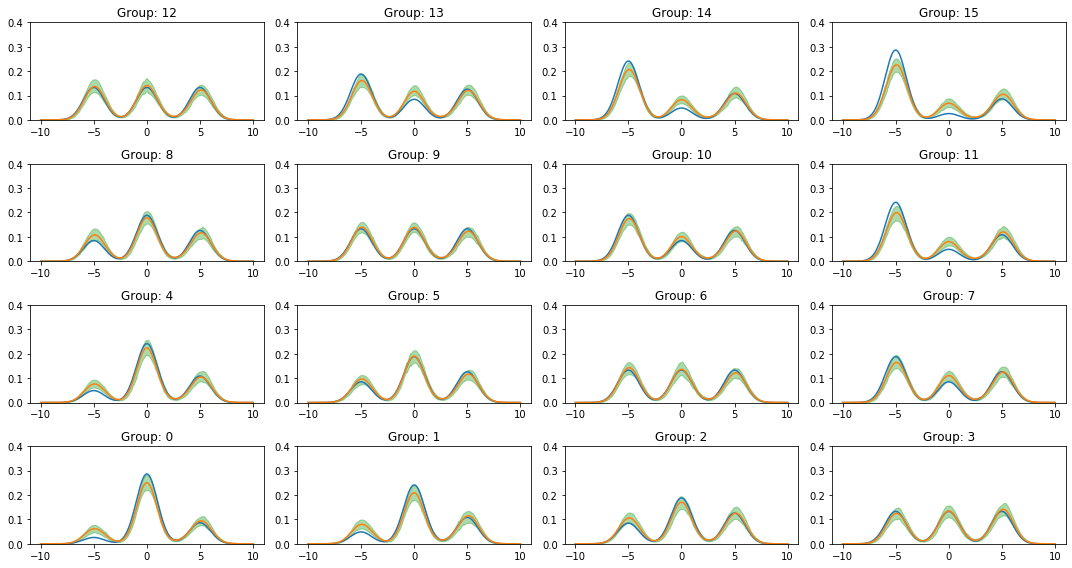

In [19]:
from scipy.stats import norm 

fig, axes = plt.subplots(nrows=int(np.floor(N/Nx)) + int(N%Nx>0), ncols=Nx, figsize=(15, 8))
#axes = axes.flat

for i in range(Ny):
    for j in range(Nx):
        g = j + Nx * i
        axes[Ny - 1 - i, j].plot(xgrid, 
                     weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                     weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                     weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
        axes[Ny - 1 - i, j].plot(xgrid, np.mean(dens[g], 0))
        axes[Ny - 1 - i, j].set_ylim([0, 0.4])
        intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.95) for i in range(dens[g].shape[1])])
        axes[Ny - 1 - i, j].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.4, color=current_palette[2])
        axes[Ny - 1 - i, j].set_title("Group: {0}".format(g))
        #sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [239]:
# plot densities

import matplotlib
import plotly
import plotly.graph_objects as go


# da cambiare in base al plot
xgrid = np.linspace(-10, 10, 500)
g = 0
true = weights[g][0] * norm.pdf(xgrid, -5, 1.0) + weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) + weights[g][2] * norm.pdf(xgrid, 5.0, 1.0)
        
estimated = np.mean(dens[g], 0)

intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.95) for i in range(dens[g].shape[1])])

# --------------------

#colors

color_true = 'rgba(255,140,0, 1)'
color_true_area = 'rgba(255,140,0, 0.)'

color_estimated = 'rgba(15, 32, 67, 1)'
color_estimated_area = 'rgba(15, 32, 67, 0.)'

color_intervals = 'rgba(122, 207, 221, 0.7)'

fig = go.Figure()

# true density
fig.add_trace(go.Scatter(x=xgrid,
                         y=true,
                         showlegend=False,
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_true),
                         fill='tozeroy',
                         fillcolor=color_true_area,
                         ))

# estimated density
fig.add_trace(go.Scatter(x=xgrid,
                         y=estimated,
                         showlegend=False,
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_estimated),
                         fill='tozeroy',
                         fillcolor=color_estimated_area,
                         ))

# Crebible intervals
fig.add_trace(go.Scatter(x=xgrid,
                         y=intervals[:, 0],
                         showlegend=False,
                         mode=None,
                         line=dict(width=0, 
                                   color=color_intervals),
                         ))
fig.add_trace(go.Scatter(x=xgrid,
                         y=intervals[:, 1],
                         showlegend=True,
                         name = '95% Credible Interval',
                         mode=None,
                         line=dict(width=0, 
                                   color=color_intervals),
                         fill='tonexty',
                         fillcolor=color_intervals,
                         ))

# estimated density
fig.add_trace(go.Scatter(x=xgrid,
                         y=estimated,
                         showlegend=True,
                         name='Estimated Density',
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_estimated),
                         ))

# true density
fig.add_trace(go.Scatter(x=xgrid,
                         y=true,
                         showlegend=True,
                         name='True Density',
                         mode='lines',
                         line=dict(width=3, 
                                   color=color_true),
                         ))



fig.update_layout(
            plot_bgcolor='rgba(0, 0, 0, 0)',
            )
fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='grey',
                 zeroline=True, zerolinewidth=0.5, zerolinecolor='grey')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='grey',
                 zeroline=True, zerolinewidth=0.5, zerolinecolor='grey',
                range=[0, 0.3])

plotly.offline.iplot(fig)